# Walmart : predict weekly sales
- Objective: Build a ML model to predict weekly sales, obtaining highest precision score possible. Explain the influence economic indicators impact sales. 

## Part 1: Exploratory Data Analysis

### Imports

In [387]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import random
import datetime

# preprocessing and machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# show all rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [388]:
df = pd.read_csv("/Users/student/Desktop/SupervisedML/Walmart_Store_sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


__Variable Keys__
- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

### Data Exploration

In [389]:
print(f"Rows: {df.shape[0]} \nColumns: {df.shape[1]}")

Rows: 150 
Columns: 8


In [390]:
# missing values
df.isna().sum()

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

In [391]:
# drop all missing values
df.dropna(inplace=True)
df.isna().sum().sum()

0

In [392]:
# any duplicates?
df.duplicated().sum()

0

In [393]:
# datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 1 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         75 non-null     float64
 1   Date          75 non-null     object 
 2   Weekly_Sales  75 non-null     float64
 3   Holiday_Flag  75 non-null     float64
 4   Temperature   75 non-null     float64
 5   Fuel_Price    75 non-null     float64
 6   CPI           75 non-null     float64
 7   Unemployment  75 non-null     float64
dtypes: float64(7), object(1)
memory usage: 5.3+ KB


In [394]:
# convert "store" and "holiday_flag" to categorical variables
df[["Store", "Holiday_Flag"]] = df[["Store", "Holiday_Flag"]].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 1 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Store         75 non-null     category
 1   Date          75 non-null     object  
 2   Weekly_Sales  75 non-null     float64 
 3   Holiday_Flag  75 non-null     category
 4   Temperature   75 non-null     float64 
 5   Fuel_Price    75 non-null     float64 
 6   CPI           75 non-null     float64 
 7   Unemployment  75 non-null     float64 
dtypes: category(2), float64(5), object(1)
memory usage: 5.1+ KB


#### Statistics

In [395]:
# amount of stores
len(np.unique(df["Store"]))

20

In [396]:
# amount of holidays
df["Holiday_Flag"].value_counts()

Holiday_Flag
0.0    68
1.0     7
Name: count, dtype: int64

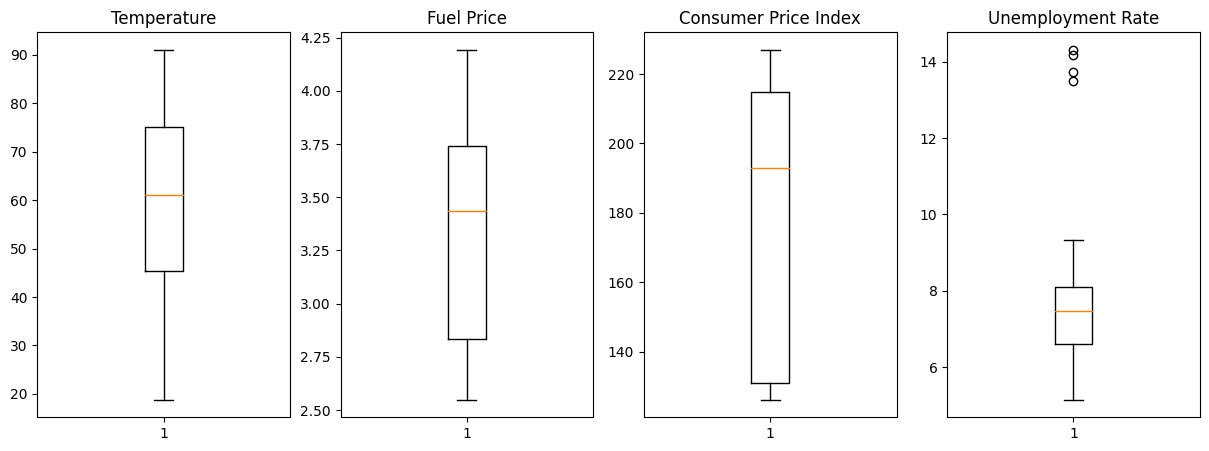

In [397]:
# view distribution for numerical variables

# create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_figwidth(15)
fig.set_figheight(5)

# first chart
ax1.boxplot(df["Temperature"])
ax1.set_title("Temperature")
# second chart
ax2.boxplot(df["Fuel_Price"])
ax2.set_title("Fuel Price")
# third chart
ax3.boxplot(df["CPI"])
ax3.set_title("Consumer Price Index")
# fourth chart
ax4.boxplot(df["Unemployment"])
ax4.set_title("Unemployment Rate")

# show
plt.show()

- _Unemployment_ seems to have several outliers, contrary to other columns. Our threshold for this project is of 3 standard deviations, or $[ X−3σ, X+3σ]$.

In [398]:
# range of -3, +3 sigmas for Unemployment
sigma_plus3 = (df["Unemployment"].mean() + df["Unemployment"].std()*3).round(2)
sigma_minus3 = -(df["Unemployment"].mean() + df["Unemployment"].std()*3).round(2)
sigma_plus3, sigma_minus3

(12.95, -12.95)

In [399]:
# remove outliers with masks
df_outliers = df[(df["Unemployment"] < sigma_plus3) & (df["Unemployment"] > sigma_minus3)]
df_outliers.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
10,8.0,19-08-2011,895066.50,0.0,82.92,3.554,219.070197,6.425


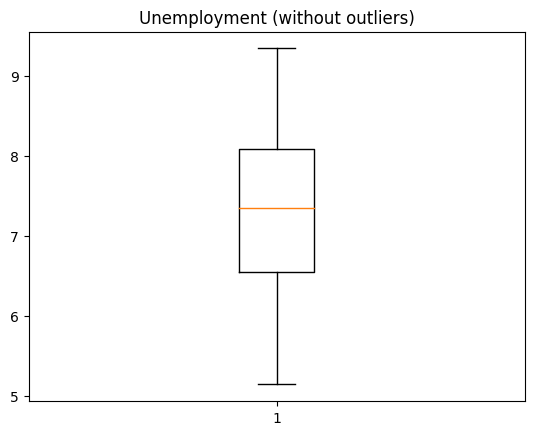

In [400]:
# redraw boxplot for "unemployment", without outliers
plt.boxplot(df_outliers["Unemployment"])
plt.title("Unemployment (without outliers)")
plt.show()

In [401]:
# declare df w/o outliers as normal df
df = df_outliers

### Data Analysis

##### What variables should we explore further?
- Correlation Analysis

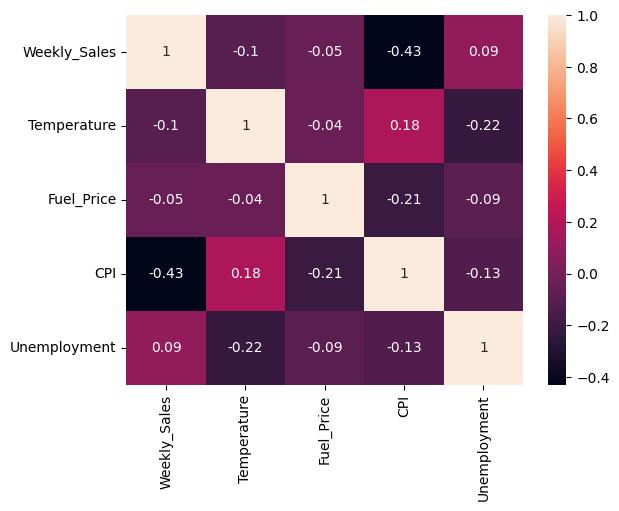

In [402]:
# correlation between numeric features
sns.heatmap(df.select_dtypes(include="number").corr().round(2),
            annot=True)
plt.show()

- CPI (consumer price index) has an important negative correlation with our target variable _weekly sales_, contrary to the rest of the variables. The lower inflation is the lower sales are. 
- Interesting to see that most variables have negative correlations between them.
- CPI seems to be the driver factor here, as it is also correlated to fuel price which makes sense, but higher temperatures lead to a higher CPI. This probably indicates that inflation might be seasonal, we should explore this relationship further with the date column.

##### Weekly Sales

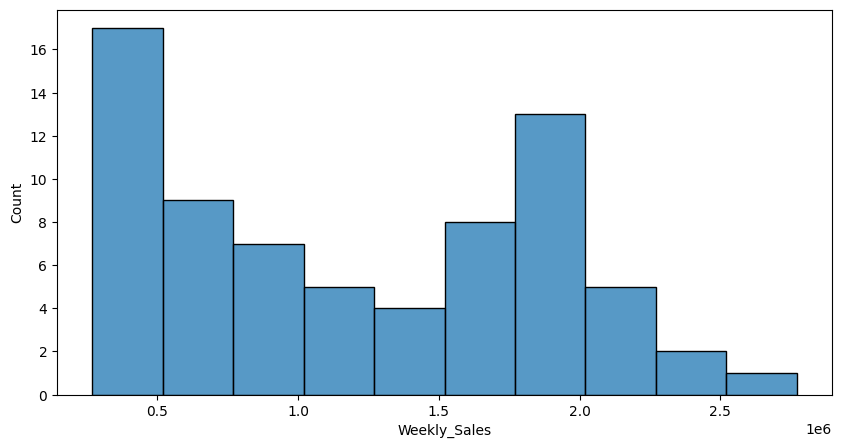

'Weekly sales average:'

1211317.93

In [403]:
# bins of 10, 250.000 each  
plt.figure(figsize=(10,5))
sns.histplot(df["Weekly_Sales"],
             bins=10)
plt.title("")
plt.show()

# average sales per week
display("Weekly sales average:", df["Weekly_Sales"].mean().round(2))

In [404]:
# weekly sales range
df["Weekly_Sales"].min(), df["Weekly_Sales"].max()

(268929.03, 2771397.17)

In [405]:
# create new column with four categories of unemployment rates
df["Weekly_Sales_bins"] = pd.cut(df["Weekly_Sales"], 
                                 bins=4,
                                 labels=["266,426.56, 894,546.065", "894,546.07, 1520163.1", "1,520,163.1, 2,145,780.14", "2,145,780.14, 2,771,397.17"])

df["Weekly_Sales_bins"].head()                

1      1,520,163.1, 2,145,780.14
4      1,520,163.1, 2,145,780.14
6        266,426.56, 894,546.065
7     2,145,780.14, 2,771,397.17
10         894,546.07, 1520163.1
Name: Weekly_Sales_bins, dtype: category
Categories (4, object): ['266,426.56, 894,546.065' < '894,546.07, 1520163.1' < '1,520,163.1, 2,145,780.14' < '2,145,780.14, 2,771,397.17']

##### How does unemployment affect weekly sales?

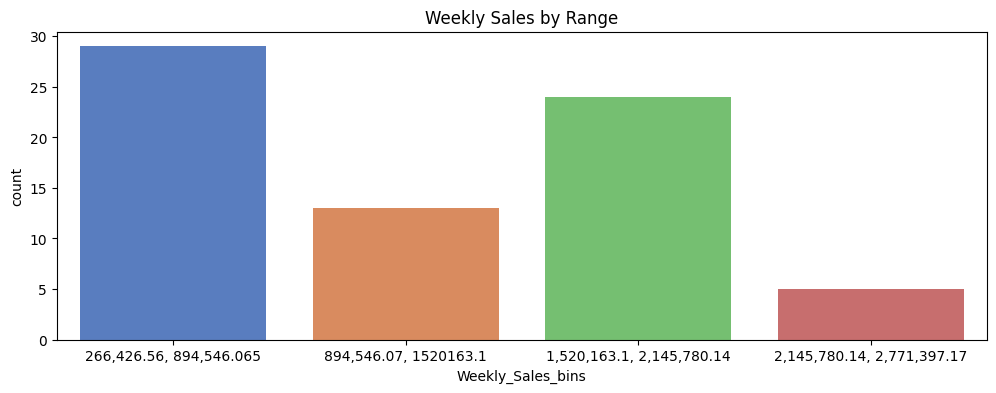

In [406]:
# read x_labels as "less than x"

plt.figure(figsize=(12,4))
sns.countplot(data=df,
              x="Weekly_Sales_bins",
              palette="muted")
plt.title("Weekly Sales by Range")
plt.show()

##### Which are the best selling stores?

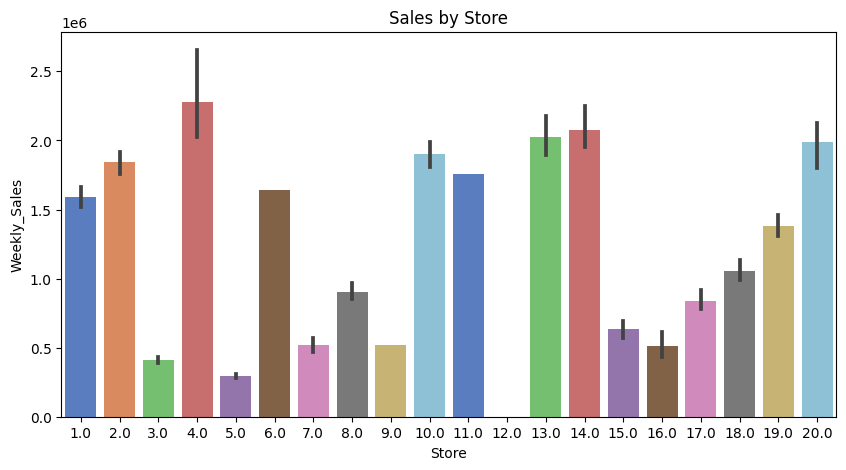

In [407]:
plt.figure(figsize=(10,5))
sns.barplot(data=df,
            x="Store",
            y="Weekly_Sales",
            palette="muted")
plt.title("Sales by Store")
plt.show()

#### Are weekly sales affected by unemployment?

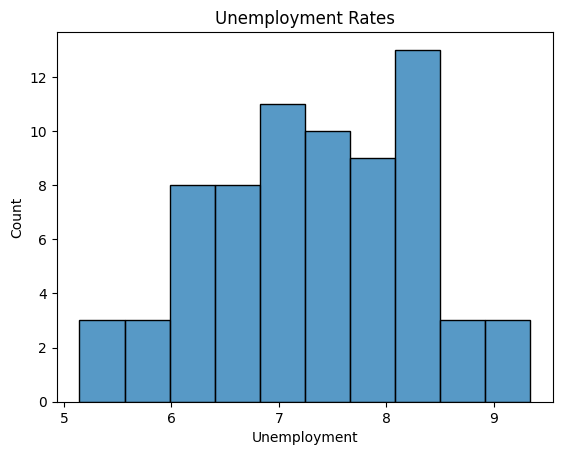

Average Unemployment Rate 7.31


In [408]:
sns.histplot(df["Unemployment"],
             bins=10)
plt.title("Unemployment Rates")
plt.show()

# show rounded mean
print("Average Unemployment Rate", df["Unemployment"].mean().round(2))

In [409]:
# create new column with four categories of unemployment rates
df["Unemployment_bins"] = pd.cut(df["Unemployment"], 
                                 bins=4,
                                 labels=["5.14, 6.19", "6.19, 7.24", "7.24, 8.29", "8.29, 9.34"])
df["Unemployment_bins"].head()

1     7.24, 8.29
4     6.19, 7.24
6     7.24, 8.29
7     6.19, 7.24
10    6.19, 7.24
Name: Unemployment_bins, dtype: category
Categories (4, object): ['5.14, 6.19' < '6.19, 7.24' < '7.24, 8.29' < '8.29, 9.34']

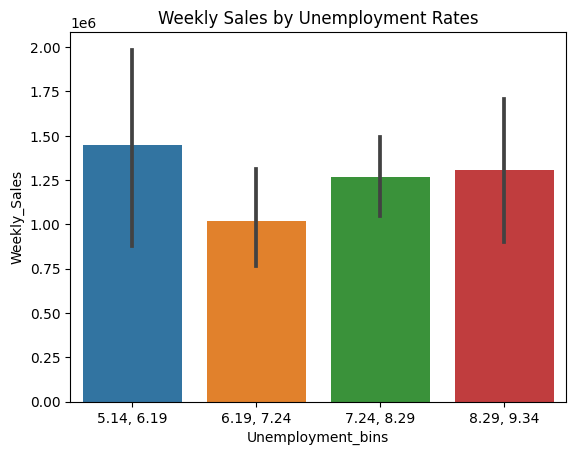

In [410]:
# how does unemployment affect weekly sales?
sns.barplot(data=df,
            x="Unemployment_bins",
            y="Weekly_Sales")
plt.title("Weekly Sales by Unemployment Rates")
plt.show()

#### What is the impact of CPI against Weekly Sales?

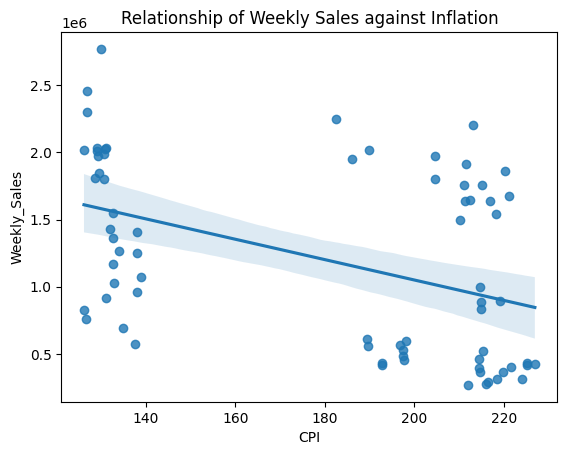

Average inflation (CPI): 178.79


In [411]:
sns.regplot(data=df,
            x="CPI",
            y="Weekly_Sales")
plt.title("Relationship of Weekly Sales against Inflation")
plt.show()

print("Average inflation (CPI):", df["CPI"].mean().round(2))

In [412]:
# CPI range
df["CPI"].min().round(2), df["CPI"].max().round(2)

(126.14, 226.97)

In [413]:
# sort rows to different labeled bins 
df["CPI_bins"] = pd.cut(df["CPI"],
                        bins=5,
                        labels=["125.9, 146.2", "146.2, 166.4", "166.4, 186.6", "186.6, 206.8", "206.8, 227.0"])
df["CPI_bins"].head()

1     125.9, 146.2
4     206.8, 227.0
6     125.9, 146.2
7     206.8, 227.0
10    206.8, 227.0
Name: CPI_bins, dtype: category
Categories (5, object): ['125.9, 146.2' < '146.2, 166.4' < '166.4, 186.6' < '186.6, 206.8' < '206.8, 227.0']

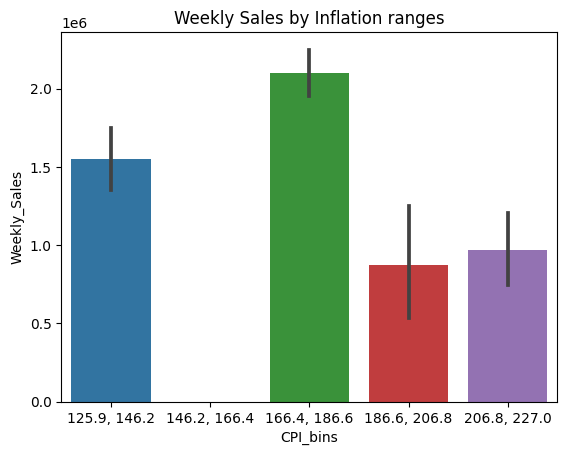

In [414]:
sns.barplot(data=df,
            x="CPI_bins",
            y="Weekly_Sales")
plt.title("Weekly Sales by Inflation ranges")
plt.show()

##### Do sales increase on holidays?

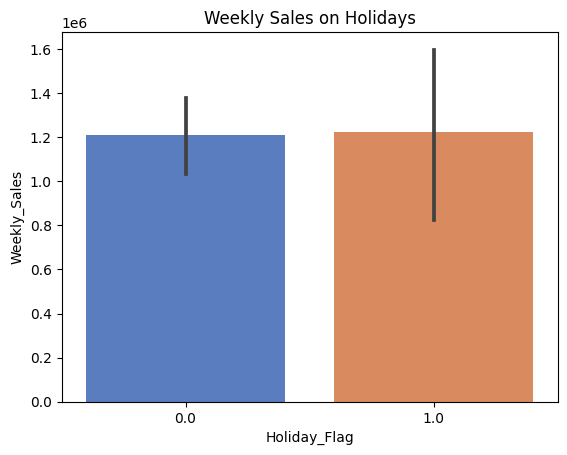

In [415]:
sns.barplot(data=df,
            x="Holiday_Flag",
            y="Weekly_Sales",
            palette="muted")
plt.title("Weekly Sales on Holidays")
plt.show()

In [416]:
# weekly sales when there is no holiday
sales_no_holiday = df[df["Holiday_Flag"]==0]["Weekly_Sales"].mean().round(2)
print("Average sales when there is no holiday:", sales_no_holiday)

Average sales when there is no holiday: 1209976.87


In [417]:
# weekly sales when there is holiday
sales_holiday = df[df["Holiday_Flag"]==1]["Weekly_Sales"].mean().round(2)
print("Average sales when there is holiday:", sales_holiday)


Average sales when there is holiday: 1225846.08


In [418]:
# difference sales when there is holiday and when there is not
print(f"Weekly sales increase by {(sales_holiday - sales_no_holiday).round(2)} when there is a holiday.")

Weekly sales increase by 15869.21 when there is a holiday.


##### Does temperature affect sales?

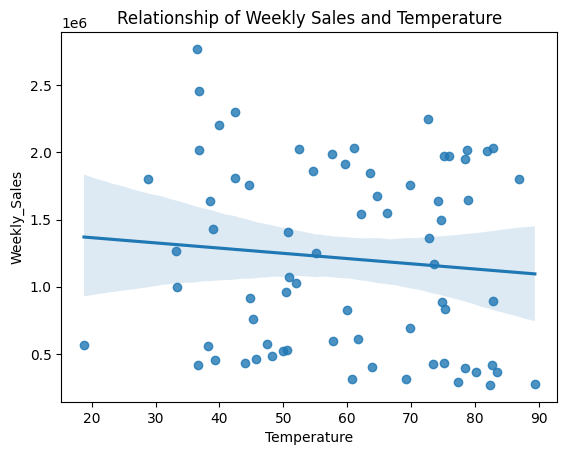

Average temperature: 59.71


In [419]:
sns.regplot(data=df,
            x="Temperature",
            y="Weekly_Sales")
plt.title("Relationship of Weekly Sales and Temperature")
plt.show()

print("Average temperature:", df["Temperature"].mean().round(2))

##### Does fuel price affect sales?

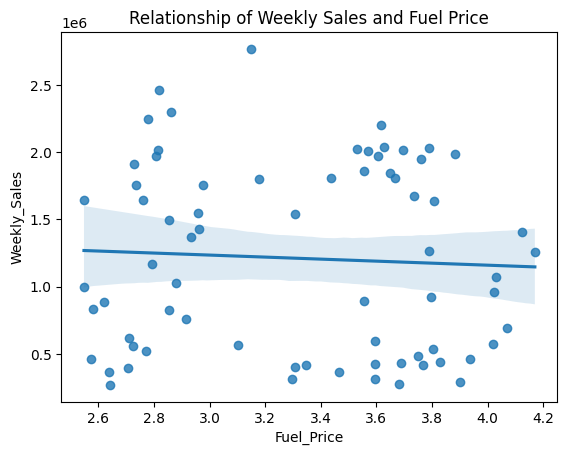

Average fuel price: 3.31


In [420]:
sns.regplot(data=df,
            x="Fuel_Price",
            y="Weekly_Sales")
plt.title("Relationship of Weekly Sales and Fuel Price")
plt.show()

print("Average fuel price:", df["Fuel_Price"].mean().round(2))

### Model Preprocessing

In [421]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_bins',
       'Unemployment_bins', 'CPI_bins'],
      dtype='object')

In [422]:
# declare x and y
X = df[["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]]
y = df["Weekly_Sales"]

display(X.head())
display(y.head())

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1,13.0,0.0,42.38,3.435,128.616064,7.470
4,6.0,0.0,78.89,2.759,212.412888,7.092
6,15.0,0.0,69.80,4.069,134.855161,7.658
7,20.0,0.0,39.93,3.617,213.023622,6.961
10,8.0,0.0,82.92,3.554,219.070197,6.425


1     1807545.43
4     1644470.66
6      695396.19
7     2203523.20
10     895066.50
Name: Weekly_Sales, dtype: float64

In [423]:
# create dummy columns for Store and Holiday
X = pd.get_dummies(X, drop_first=True,dtype="float")
X.head()

,Temperature,Fuel_Price,CPI,Unemployment,Store_2.0,Store_3.0,Store_4.0,Store_5.0,Store_6.0,Store_7.0,Store_8.0,Store_9.0,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Holiday_Flag_1.0
1,42.38,3.435,128.616064,7.470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78.89,2.759,212.412888,7.092,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,69.80,4.069,134.855161,7.658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,39.93,3.617,213.023622,6.961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10,82.92,3.554,219.070197,6.425,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [424]:
# train test split
# train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# sanity check 
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

56 15
56 15


## Part 2: Train baseline model
- First model won't include date

### Model 1: Baseline Model

In [425]:
# train baseline model
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [426]:
# make predictions
model1_train_pred = model1.predict(X_train)
model1_test_pred = model1.predict(X_test)

In [427]:
model1_train_score = model1.score(X_train, y_train).round(4)
model1_test_score = model1.score(X_test, y_test).round(4)

print(f"R2 score for TRAIN set:, {model1_train_score}")
print(f"R2 score for TEST set:, {model1_test_score}")
print("Difference between train and test:", (model1_train_score - model1_test_score).round(4))

R2 score for TRAIN set:, 0.9839
R2 score for TEST set:, 0.8985
Difference between train and test: 0.0854


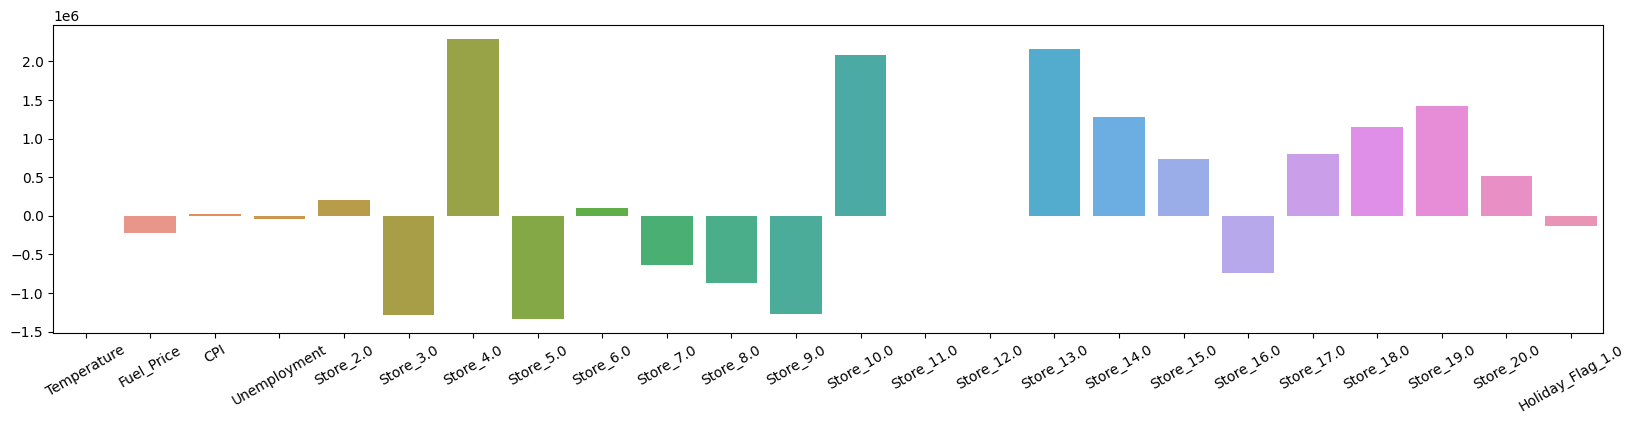

In [428]:
# coefficients of linear model
# in other words, how each variable affects the model
plt.figure(figsize=(20,4))
sns.barplot(x=X.columns,
            y=model1.coef_)
plt.xticks(rotation=30)
plt.show()

Observations:
- Good train and test scores
- _Store_ variable has highest impact on model coefficients, practically erasing other variables like _Temperature_ and specially _CPI_, which on paper has the biggest impact on scores.
- Because of that we are going to remove the variable and see what happens.

### Model 2

In [429]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_bins',
       'Unemployment_bins', 'CPI_bins'],
      dtype='object')

In [430]:
# declare once again, without "Store", x and y train
X = df[["Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]]
y = df["Weekly_Sales"]

In [431]:
# train test split again
# train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# sanity check
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

56 15
56 15


In [432]:
# train model
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression()

In [433]:
# predictions
model2_train_pred = model2.predict(X_train)
model2_test_pred = model2.predict(X_test)

In [434]:
# R2 score
model2_train_score = model2.score(X_train, y_train).round(4)
model2_test_score = model2.score(X_test, y_test).round(4)

print(f"R2 score for TRAIN set:, {model2_train_score}")
print(f"R2 score for TEST set:, {model2_test_score}")
print("Difference between train and test:", (model2_train_score - model2_test_score).round(4))

R2 score for TRAIN set:, 0.2486
R2 score for TEST set:, -0.092
Difference between train and test: 0.3406


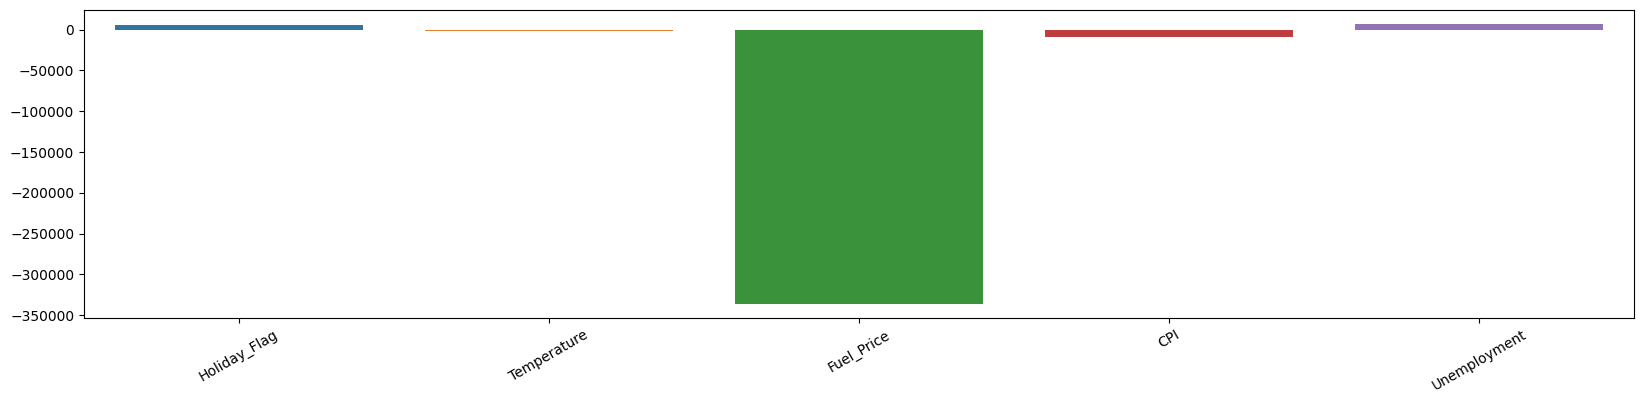

In [435]:
# coefficients of linear model
# in other words, how each variable affects the model
plt.figure(figsize=(20,4))
sns.barplot(x=X.columns,
            y=model2.coef_)
plt.xticks(rotation=30)
plt.show()

Observations:
- This is clearly a much worse model than if we included the _Store_ variable, indicating that it is an important predictor.
- _Store_ will be added back to the model, and we will train a regularized model to see if we can increase accuracy.

## Part 3: Train regularized model

### Model 3

In [436]:
# model 1 scores, our target for model 3
model1_train_score, model1_test_score

(0.9839, 0.8985)

In [437]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_bins',
       'Unemployment_bins', 'CPI_bins'],
      dtype='object')

In [442]:
# declare x and y
X = df[["Store", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]]
y = df["Weekly_Sales"]

In [443]:
# create dummy columns for Store and Holiday
X = pd.get_dummies(X, drop_first=True, dtype="float")
X.head()

,Temperature,Fuel_Price,CPI,Unemployment,Store_2.0,Store_3.0,Store_4.0,Store_5.0,Store_6.0,Store_7.0,Store_8.0,Store_9.0,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Holiday_Flag_1.0
1,42.38,3.435,128.616064,7.470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78.89,2.759,212.412888,7.092,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,69.80,4.069,134.855161,7.658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,39.93,3.617,213.023622,6.961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10,82.92,3.554,219.070197,6.425,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [444]:
# train test split
# train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# sanity check 
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

56 15
56 15


In [ ]:
# train regularization model